# TensorFlow - Image Classification

### The objective is to build models to classify a series of images into one of ten classes. 

In [3]:
import numpy as np
import gzip

train_images = np.load(gzip.open('train_images.npy.gz', 'rb'))
train_labels = np.load(gzip.open('train_labels.npy.gz', 'rb'))
validation_images = np.load(gzip.open('validation_images.npy.gz', 'rb'))

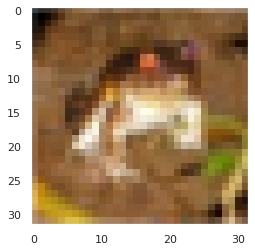

In [4]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(train_images[0])

In [7]:
train_labels[0]

6

In [10]:
train_labels

array([6, 9, 9, ..., 9, 1, 1])

In [8]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [9]:
label_names[train_labels[0]]

'frog'

### First, I'll measure the difference between two images, and choose the label corresponding to nearby images. I make the simplifying assumption that this is just the average difference between the colors of the corresponding pixels in the two images.

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

### This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.


In [21]:
import tensorflow as tf

@tf.function
def delta_func(images, base): 

    def color_diff(x,y):
                r_diff = tf.square(tf.subtract(x[:,:,0], y[:,:,0]))
                g_diff = tf.square(tf.subtract(x[:,:,1], y[:,:,1]))
                b_diff = tf.square(tf.subtract(x[:,:,2], y[:,:,2]))
                C_d = tf.sqrt(2*r_diff + 4*g_diff + 3*b_diff + tf.divide(tf.add(x[:,:,0], y[:,:,0]),2) * (r_diff - b_diff))
                return tf.reduce_sum(C_d / (32*32)) 
    
    return tf.map_fn(lambda i: color_diff(i, base), images)
        

In [22]:
delta_func(train_images[:10], train_images[0])


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([0.        , 0.80592716, 1.1263453 , 0.46740696, 0.8712157 ,
       0.70549786, 0.77343273, 0.8241726 , 1.1291139 , 0.9068342 ],
      dtype=float32)>

#### As stated, for two images, $I_1$ and $I_2$, I define the distance between $I_1$ and $I_2$ as the average $\Delta C$ value over the whole image, that is:

$$d(I_1, I_2) = \frac{1}{N}\sum_{p_j} \Delta C(p_j)$$
where the sum is over all pixels $p_j$, $\Delta C(p_2)$ is the $\Delta C$ value for the pixel $p_j$, and $N$ is the total number of pixels in each image ($N= 32\times 32$ in our case).

#### Using `delta_func` I compute the distance between the first validation image and all of the training images.

In [24]:
deltas = delta_func(train_images, validation_images[0]).numpy()

In [26]:
indices = list(deltas.argsort()[:100])

### Now, I'll let neural networks figure out how to connect pixel values to classes starting with something that barely qualifies as a neural network: a softmax classifier. 

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
train_images.shape

(50000, 32, 32, 3)

In [4]:
from tensorflow.keras.utils import to_categorical as one_hot

In [6]:
train_labels_hot = one_hot(train_labels)

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(32,32,3)),
        keras.layers.Dense(10, activation='softmax')   
    ])

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels_hot, epochs=100)

In [17]:
y_pred = model.predict(validation_images)

In [18]:
predicted_classes = [np.argmax(i) for i in y_pred]

### Next, I add a hidden layer to this network.

In [7]:
hidden_size = 64

In [ ]:
model = keras.models.Sequential([
        keras.layers.Flatten(input_shape=(32,32,3)),
        keras.layers.Dense(hidden_size, 
                           activation='sigmoid',
                           kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
                          )
                            
    ])

model.add(keras.layers.Dense(units=10, activation='softmax'))

model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_images, train_labels_hot, epochs=100)

In [9]:
y_pred = model.predict(validation_images)
predicted_classes = [np.argmax(i) for i in y_pred]

### I next build a neural network with convolutional layers to improve the performance.

In [4]:
import tensorflow as tf
from tensorflow import keras

In [5]:
from sklearn.model_selection import train_test_split


In [6]:
from tensorflow.keras.utils import to_categorical as one_hot
train_labels_hot = one_hot(train_labels)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels_hot, test_size = 0.05, random_state = 0)

In [8]:
img_size = 32
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1
filt_size = [5, 5] # 5x5 pixel filters

batch_size = 128
n_epochs = 30

In [9]:
model = keras.models.Sequential()

model.add(keras.layers.Reshape([img_size, img_size, 3]))
model.add(keras.layers.Conv2D(16, filt_size, padding='same',
                              activation='relu'))

In [10]:
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))

In [11]:
model.add(keras.layers.Dropout(.5))

In [12]:
model.add(keras.layers.Flatten())


In [13]:
model.add(keras.layers.Dense(100, activation='relu'))


In [14]:
model.add(keras.layers.Dense(n_classes, activation='softmax'))


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))

In [16]:
y_pred = model.predict(validation_images)
predicted_classes = [np.argmax(i) for i in y_pred]

### Finally, I use a network trained on one data set to provide a starting point: the Inception network used in the Deep Dream notebook hy Google.


In [21]:
# include_top=False will discard avg_pool before prediction layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # manually discard prediction layer

In [10]:
lst = [inception(tf.image.resize(train_images[i*50:(i+1)*50], (299,299))) for i in range(0, 1000)]

In [ ]:
lst

In [11]:
import numpy as np

In [12]:
with open("vectors.npy", "wb") as f:
    np.save(f, lst)

In [6]:
latent_vectors = np.load(open("vectors.npy", 'rb'))

In [8]:
latent = np.concatenate(latent_vectors)

In [9]:
latent.shape

(50000, 2048)

In [10]:
from tensorflow.keras.utils import to_categorical as one_hot
train_labels_hot = one_hot(train_labels)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(latent, train_labels_hot, test_size = 0.1, random_state = 0)

In [12]:
pixels = 299 * 299 * 3
n_classes = 10
n_channels = 1
filt_size = [5, 5] # 5x5 pixel filters

batch_size = 128
n_epochs = 30
hidden_size=64

In [15]:
model = keras.models.Sequential()

model.add(keras.layers.Dense(
    hidden_size,
    activation = 'sigmoid',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=pixels**-0.5)
    )
)
          
model.add(keras.layers.Dense(
    10,
    activation='softmax',
    kernel_initializer=keras.initializers.TruncatedNormal(stddev=hidden_size**-0.5)
    )
 )


In [16]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train,
                   epochs=5,
                    batch_size=batch_size,
                    validation_data=(X_test,y_test))

Epoch 1/5
352/352 [==============================] - 1s 2ms/step - loss: 0.8420 - accuracy: 0.7699 - val_loss: 0.5519 - val_accuracy: 0.8166
Epoch 2/5
352/352 [==============================] - 1s 2ms/step - loss: 0.5033 - accuracy: 0.8331 - val_loss: 0.4667 - val_accuracy: 0.8374
Epoch 3/5
352/352 [==============================] - 1s 2ms/step - loss: 0.4434 - accuracy: 0.8488 - val_loss: 0.4404 - val_accuracy: 0.8436
Epoch 4/5
352/352 [==============================] - 1s 2ms/step - loss: 0.4069 - accuracy: 0.8612 - val_loss: 0.4322 - val_accuracy: 0.8438
Epoch 5/5
352/352 [==============================] - 1s 2ms/step - loss: 0.3791 - accuracy: 0.8717 - val_loss: 0.4346 - val_accuracy: 0.8474


In [22]:
lst2 = [inception(tf.image.resize(validation_images[i*50:(i+1)*50], (299,299))) for i in range(0, 200)]

In [23]:
with open("vectors2.npy", "wb") as f:
    np.save(f, lst2)

In [24]:
val_vectors = np.load(open("vectors2.npy", 'rb'))

In [25]:
validation = np.concatenate(val_vectors)

In [27]:
validation.shape

(10000, 2048)

In [28]:
y_pred = model.predict(validation)
predicted_classes = [np.argmax(i) for i in y_pred]